# Google Earth Engine- Plotting Fire Data on a Bubble Map 

My name is Winifred, and I am a second-year student studying Computer Science at UC Berkeley. I was first exposed to data science one year ago and quickly realized just how applicable it is to various fields of study. After joining the Cabinet of Curiosity team, I learned more about existing natural history databases and collaborated with other team members to dive into and study these databases. I became particularly interested in the [Google Earth Engine database](https://earthengine.google.com/) and the vast amount of geophysical, climate, and imagery data it contained. Data visualization was also something I wanted to learn more about, which led me to exploring California wildfire data from the Earth Engine database and using Plotly to create a map that represented this data.. 

## Acquiring Data From Google Earth Engine

Google Earth Engine hosts satellite imagery and other geospatial data and is a tool that allows for analysis of these datasets, which are made available for global-scale data mining. Images of Earth may go back more than 40 years and are ingested on a daily basis. Datasets include the USGS/NASA Landsat catalog, precipitation data, elevation data, and many more. Earth Engine also allows users to upload their own data for analysis. 

Earth Engine has been used in many interesting case studies, such as the [Map of Life](http://species.mol.org/species/map/Perdix_dauurica), as well as analysis of [global forest cover change](http://species.mol.org/species/map/Perdix_dauurica).

## Downloading Data 

Browse the [Data Catalog](https://developers.google.com/earth-engine/datasets/catalog/) to find a dataset that interests you. I picked one that contains [data about fires](https://developers.google.com/earth-engine/datasets/catalog/FIRMS). Notice the link  listed under the "Dataset Provider" section.

<img src = "../images/dataset_provider.PNG">


FIRMS provides "active fire data", which consists of data from the past 24 hours, 48 hours, and 7 days. However, because FIRMS data dates back to November 2000, I wanted to know how to download data older than 7 days.

Once you've reached the FIRMS dataset provider link, scroll down and select "Archive Download." Then, click on "Create New Request." 

<img src='../images/nasa_page.PNG'>

<img src='../images/archive_page.png'>

I wanted to narrow down the data to Southern California wildfires, so in the Download Request box, I decided to get data on a custom region and drew a polygon that roughly enclosed California. For fire data source, I chose VIIRS, which is an instrument  used to detect fires and gather data. My date range of choice was September 1st 2017 to September 1st 2018, and I decided to download it as a .csv file. Finally, you must enter your email so that FIRMS can send the data to you. You should receive an email within a few days.

<img src='../images/download_request.png'>

Once you receive the email, just download the .csv file, and you're ready to go! 

## Using Plotly for Python 

[Plotly](https://plot.ly/#/) has a [Python library](https://plot.ly/python/) that allows you to create interactive data visualizations online, such as line plots, scatter maps, heatmaps, and 3D network graphs. In this tutorial, we will create a bubble map that visualizes wildfire data in California (based on the FIRMS data we acquired). 

I knew I wanted to visualize the data using a map, and after looking at many different graphing libraries, I decided to use Plotly. Plotly seemed to be the most user-friendly because the website had very thorough [map tutorials](https://plot.ly/python/maps/) and easy-to-follow [documentation](https://plot.ly/python/reference/#scattergeo). Additionally, Plotly hosts graphs, which can be embedded anywhere. These graphs are saved in your account.  

First, install Plotly's Python package using

``` pip install plotly```

Next, [create an account](https://plot.ly/Auth/login/?action=signup&next=%2Fsettings%2Fapi#/) and obtain your API key. This will be used to set your credentials. 

Now, you're ready to fire up Python and set up your credentials: 

```import plotly 
plotly.tools.set_credentials_file(username='your_username', api_key='your_api_key') ```


Once that is done, let's import some libraries that we will use in this tutorial:

In [1]:
import plotly.plotly as py
import pandas as pd
from datascience import *
import numpy as np

#included for distribution figures.
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

## Using the FIRMS dataset

Our FIRMS dataset is quite big, so let's narrow it down to just a few points on the map. I'd like to plot 5 bright, 5 moderately bright, and 5 dim wildfires in the dataset. 

First, let's load the .csv file into a table:

In [2]:
data= pd.read_csv('../data/SoCal_fires.csv')  
data.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,type
0,36.234,-118.430,321.9,1.0,1.0,2017-10-07,1845,Terra,MODIS,44,6.1,302.5,14.5,0
1,36.258,-118.421,319.4,4.7,2.0,2017-10-15,1756,Terra,MODIS,72,6.1,294.9,138.7,0
2,36.259,-118.425,318.2,4.7,2.0,2017-10-15,1756,Terra,MODIS,44,6.1,294.4,118.3,0
3,36.256,-118.420,345.1,1.1,1.0,2017-10-15,2112,Aqua,MODIS,92,6.1,298.3,50.0,0
4,36.272,-118.429,326.3,1.1,1.0,2017-10-16,1839,Terra,MODIS,71,6.1,293.0,23.1,0


## Filtering the data

Now, let's select our columns of interest. For the purposes of this tutorial, we care about the latitude, longitude, brightness, and dates of our data.

In [3]:
# list(data) # list all the column names
py_data = data[['latitude', 'longitude', 'brightness', 'acq_date']] #pandas
py_data.head()

,latitude,longitude,brightness,acq_date
0,36.234,-118.430,321.9,2017-10-07
1,36.258,-118.421,319.4,2017-10-15
2,36.259,-118.425,318.2,2017-10-15
3,36.256,-118.420,345.1,2017-10-15
4,36.272,-118.429,326.3,2017-10-16


## Subsetting the data 

Now, let's subset and look at the distribution of the data. We probably wouldn't expect there to be an equal amount of fires throughout the varying degrees of brightness; if that were the case, we'd have just as many small, dim fires as large, intense fires. 


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



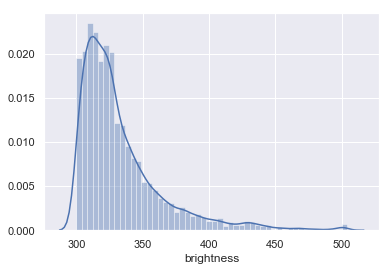

In [4]:
## Let's look at the distribution of the brightness.
%matplotlib inline

sns.set(color_codes=True)
sns.distplot(py_data['brightness'])

In [5]:
## Split into three quanitles.
py_data['quantile'] = pd.qcut(py_data['brightness'], 3, labels=["dim", "moderate", "bright"]) 
py_data.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,latitude,longitude,brightness,acq_date,quantile
0,36.234,-118.430,321.9,2017-10-07,moderate
1,36.258,-118.421,319.4,2017-10-15,moderate
2,36.259,-118.425,318.2,2017-10-15,moderate
3,36.256,-118.420,345.1,2017-10-15,bright
4,36.272,-118.429,326.3,2017-10-16,moderate


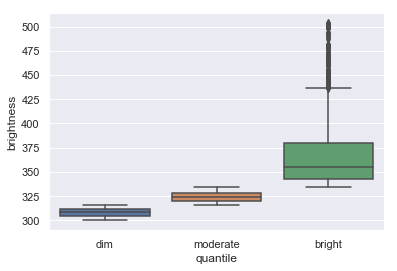

In [7]:
sns.boxplot(data=py_data, x='quantile', y='brightness')
#sns.distplot(py_data['brightness'], hue='quantile')

As we can see, the dataset contains a lot more dim fires. Because there is an uneven distribution of fires per degree of brightness, we will randomly sample from each quantile. I will first split up the table by quantile, and then sample from each table. 

In [8]:
#filter out the tables 
dim_data = py_data[py_data["quantile"] == "dim"]
moderate_data = py_data[py_data["quantile"] == "moderate"]
bright_data = py_data[py_data["quantile"] == "bright"]

In [9]:
#take 5 samples from the dim fires data
dim_sample = dim_data.sample(n=5)
moderate_sample = moderate_data.sample(n=5)
bright_sample = bright_data.sample(n=5)

,latitude,longitude,brightness,acq_date,quantile
5196,36.524,-119.922,308.7,2017-11-14,dim
3480,36.975,-120.192,303.2,2017-12-21,dim
5124,35.779,-119.220,309.9,2018-03-03,dim
3169,36.379,-119.903,301.6,2017-12-21,dim
4548,34.427,-118.969,301.9,2017-12-12,dim


Now that we have sampled from each quantile, let's create a new table with all of the sampled data. 

In [26]:
#append the dataframes to each other and sort by increasing brightness
sorted_samples = dim_sample.append(moderate_sample).append(bright_sample).sort_values("brightness")
sorted_samples

,latitude,longitude,brightness,acq_date,quantile
3169,36.379,-119.903,301.6,2017-12-21,dim
4548,34.427,-118.969,301.9,2017-12-12,dim
3480,36.975,-120.192,303.2,2017-12-21,dim
5196,36.524,-119.922,308.7,2017-11-14,dim
5124,35.779,-119.220,309.9,2018-03-03,dim
3302,37.744,-121.412,317.5,2018-05-31,moderate
5906,34.521,-119.552,318.5,2017-12-11,moderate
3536,37.082,-120.361,320.2,2017-10-30,moderate
4970,34.600,-120.074,322.4,2017-09-25,moderate
5575,36.152,-118.785,329.9,2017-09-02,moderate


In [27]:
#fix the indices
sorted_samples.index = range(15)

## Plotting the data

Here's where things get a bit tricky. Ultimately, we would like to plot a figure with a specific set of data and a specific layout. Plotly has many attributes to help us accomplish our goal, but how do we know which ones to use? Luckily, Plotly has a [figure reference!](https://plot.ly/python/reference/)

Let's initialize our data first. We want to have different-colored bubbles on our bubble map so that we can differentiate between the three levels of brightness. Let's create a list of colors to choose from, using their RGB values. I will use yellow for dim fires, orange for moderately bright fires, and red for bright fires. 

In [28]:
colors = ["rgb(255,255,0)", "rgb(255,128,0)", "rgb(255,0,0)"] #yellow, orange, red

Next, we'll create a list called limits. Limits contains three elements, and each element contains the beginning index and ending index of a brightness level. This list will allow us to map certain attributes to a specific range of data. For example, if we assign the first element of [colors] to the first element in [limits], the 5 brightest fires will appear as red bubbles on the map.

In [29]:
limits=[(0,5),(5,10),(10,15)] #we are grouping by brightness, where first five (0,5) are brightest, second group of five (5,10) are moderately bright, etc.

Now, it's time to create a list that contains all the information that we want to represent on the map. We'll call this list "fires." In the end, we want this list to hold three dictionaries (one for each brightness level). 

Since we have three brightness levels, we want to assign specific attributes to each of them. To do this, we will iterate through each of the groups and create a dictionary of attributes for each. If you are unclear about these attributes, refer to the [figure reference!](https://plot.ly/python/reference/).

In [30]:
fires=[] #the data that we want to represent on the map
    
for i in range(len(limits)): #we want to iterate 3 times to create 3 traces on the map 
    #for the purpose of scaling the size of each bubble, we will divide by a factor and also scale this factor so we get a bigger
    #variation in size 
    if i == 0: 
        scale = 17*1.2
    elif i == 2: 
        scale = 17*0.8
    else: 
        scale = 17
    group = sorted_samples.loc[np.r_[limits[i][0]:limits[i][1]]]
    fire=dict(
        type = 'scattergeo', #the type of figure we want to create 
        locationmode = 'USA-states', 
        lon = group['longitude'],
        lat = group['latitude'],
         #sets the properties of the bubbles 
        marker=dict(
                #scale the size of the bubble; our bubble size is based on the brightness 
                size = group["brightness"].at[limits[i][0]]/scale, #difference in size is too subtle if we just use one number for scale
                color=colors[i], #the color of the bubbles in this group 
                line = dict(width=0.5, color='rgb(40,40,40)'), 
                sizemode='diameter'
                ),
        name='{0}-{1}'.format(limits[i][0], limits[i][1])) #legend labels
    fires.append(fire)

You can see what our "fires" dictionary looks like by just calling the data `fires`. 

Next, we will dictate what our figure layout should be.  The first part of this code essentially sets the stage for your visualization. The last line does the plotting   

In [33]:
layout=dict(
        title='Range of Wildfire Brightnesses in California from 09/01/2017 to 09/01/2018',
        showlegend=True,
        geo = dict(
            projection=dict( type='albers usa'), #provides the gray USA map 
            center=dict(lon=-116.4194, lat=34.9592), #centers the map on the middle of SoCal when you first create the map
            zoom=6, #Zoom factor of map when you create it 
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )
fig = dict(data=fires, layout=layout) #our figure with fires data and the layout we want 

py.iplot(fig, validate=False, filename='SoCal-FIRMS-bubble-map') #plot the data! 

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~iamciera/0 or inside your plot.ly account where it is named 'SoCal-FIRMS-bubble-map'


/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## Add more data points! 
Here, I am just doing the same steps but getting a total of 300 data points in the end and tweaking the map.

In [36]:
brightest100=bright_data.sample(n=100).sort_values('brightness')
brightest100.head()

,latitude,longitude,brightness,acq_date,quantile
2807,36.611,-119.436,334.5,2018-05-29,bright
3958,36.069,-118.769,334.7,2017-09-16,bright
1412,37.955,-120.030,334.7,2017-11-07,bright
2470,34.509,-119.204,334.7,2017-12-15,bright
3954,36.096,-118.650,335.0,2017-09-10,bright


In [37]:
dimmest100=dim_data.sample(n=100).sort_values('brightness')
moderate100= moderate_data.sample(n=100).sort_values('brightness')
sorted_300=dimmest100.append(moderate100).append(brightest100)

I also wanted to label each bubble with the brightness value and the date of acquisition, so I first created a new "label" column in nthe sorted_300 table.

In [38]:
#create a new "label" column that combines the brightness and acquisition date, separated by a comma
sorted_300["label"] = sorted_300['brightness'].astype(str) + ', ' + sorted_300['acq_date'].astype(str)
sorted_300.head()

,latitude,longitude,brightness,acq_date,quantile,label
5044,36.971,-119.957,300.0,2017-12-04,dim,"300.0, 2017-12-04"
1440,37.020,-120.179,300.2,2017-11-27,dim,"300.2, 2017-11-27"
70,34.260,-118.385,300.3,2017-12-06,dim,"300.3, 2017-12-06"
3133,36.759,-120.227,300.4,2017-11-29,dim,"300.4, 2017-11-29"
3594,36.384,-120.310,300.4,2017-09-15,dim,"300.4, 2017-09-15"


In [39]:
#example of a single label 
sorted_300["label"].iloc[0]

'300.0, 2017-12-04'

Then, I added a "text" attribute to the fire dictionary and set it equal to a specific splice of the "labels300" array. I also changed the trace names in the legend by creating a new list of labels called "legend labels" and editing the "name" attribute in the fire dictionary.

In [40]:
limits300=[(0,100),(100,200),(200,300)]
legendlabels=['Dim', 'Moderate','Bright'] #new legend labels 
fires300=[] 
for i in range(len(limits)): 
    if i == 0: 
        scale = 17*1.2
    elif i == 2: 
        scale = 17*0.8
    else: 
        scale = 17
    #group=filtered_data300.take(range(limits300[i][0], limits300[i][1])) 
    group300 = sorted_300.loc[np.r_[limits300[i][0]:limits300[i][1]]]
    fire300=dict(
        type = 'scattergeo',
        locationmode = 'USA-states', 
        lon = group300['longitude'],
        lat = group300['latitude'],
        #text= labels300[range(limits300[i][0], limits300[i][1])],
        text = sorted_300["label"].iloc[np.r_[limits300[i][0]:limits300[i][1]]],
        location=['California'], 
        marker=dict(
                size= group300["brightness"].at[limits300[i][0]]/scale, 
                color=colors[i], 
                line = dict(width=0.5, color='rgb(40,40,40)'), 
                sizemode='diameter',
                opacity=0.7 #make the bubbles see-through
                ), 
        name=legendlabels[i]) 
    fires300.append(fire300)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



Now it's time to visualize everything!

In [43]:
layout300=dict(
        title='Range of Wildfire Brightnesses in California from 09/01/2017 to 09/01/2018',
        showlegend=True, 
        geo = dict(
            projection=dict( type='albers usa'), 
            center=dict(lon=-119.4179, lat=36.7783), 
            showland = True,
            landcolor = 'rgb(64,64,64)', #changed color of map to dark gray 
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )
fig2 = dict(data= fires300, layout= layout300)
py.iplot(fig2, validate=False, filename='FIRMS300-bubble-map') 

/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## Using the CA Oct 2017- Apr 2018 dataset

The `ca1718.csv` file contians FIRMS data for Calfornia's 2017-2018 fire season, which lasts from October to April. I performed the same actions as above, taking a total of 300 data points for the visualization.

In [44]:
data1718=pd.read_csv('../data/ca1718.csv')[['latitude', 'longitude', 'bright_ti4', 'acq_date']]
data1718.head()

,latitude,longitude,bright_ti4,acq_date
0,40.73124,-124.00435,295.3,2017-11-30
1,40.64605,-123.88713,336.2,2018-04-25
2,39.94927,-120.95713,326.1,2017-11-06
3,39.65937,-121.01781,327.8,2017-11-28
4,39.69487,-121.00845,331.8,2017-11-28


## Subsetting the data

In order to properly subset that data.  I want to understand the data distribution, that way I make sure that the subset I am making reflect the real distribution of the data.

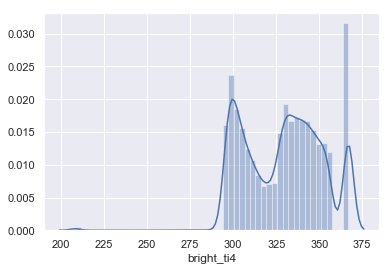

In [47]:
## Let's lool at the distribution of the brightness.
%matplotlib inline

sns.set(color_codes=True)
sns.distplot(data1718['bright_ti4'])

In [49]:
# I split into quantiles and subset by that. 
data1718['quantile'] = pd.qcut(data1718['bright_ti4'], 3, labels=["dim", "moderate", "bright"])
data1718= data1718.sort_values('bright_ti4')
data1718.head()

,latitude,longitude,bright_ti4,acq_date,quantile
18447,35.39388,-120.07444,208.0,2017-11-23,dim
30230,36.50272,-120.37718,208.0,2018-01-25,dim
13305,34.52004,-119.49242,208.0,2017-12-10,dim
18608,35.54568,-119.49454,208.0,2018-02-19,dim
17305,34.48457,-119.09801,208.0,2017-12-06,dim


In [50]:
dim1718 = data1718[data1718['quantile'] == 'dim'].sample(100).sort_values('bright_ti4')
moderate1718 = data1718[data1718['quantile'] == 'moderate'].sample(100).sort_values('bright_ti4')
bright1718 = data1718[data1718['quantile'] == 'bright'].sample(100).sort_values('bright_ti4')

In [51]:
sorted_1718 = dim1718.append(moderate1718).append(bright1718)
sorted_1718.index = range(300)
sorted_1718.head()

,latitude,longitude,bright_ti4,acq_date,quantile
0,35.38683,-120.05407,208.0,2017-11-23,dim
1,34.35557,-116.85098,295.1,2017-10-04,dim
2,36.33820,-118.51682,295.2,2017-10-05,dim
3,34.04135,-117.82120,295.4,2018-01-31,dim
4,39.39941,-123.14323,295.4,2017-10-15,dim


In [52]:
#creating the "label" column
sorted_1718["label"] = sorted_1718['bright_ti4'].astype(str) + ', ' + sorted_1718['acq_date'].astype(str)
sorted_1718.head()

,latitude,longitude,bright_ti4,acq_date,quantile,label
0,35.38683,-120.05407,208.0,2017-11-23,dim,"208.0, 2017-11-23"
1,34.35557,-116.85098,295.1,2017-10-04,dim,"295.1, 2017-10-04"
2,36.33820,-118.51682,295.2,2017-10-05,dim,"295.2, 2017-10-05"
3,34.04135,-117.82120,295.4,2018-01-31,dim,"295.4, 2018-01-31"
4,39.39941,-123.14323,295.4,2017-10-15,dim,"295.4, 2017-10-15"


In [53]:
limits1718=[(0,100),(100,200),(200,300)]
legendlabels=['Bright','Moderate', 'Dim']
fires1718=[] 
for i in range(len(limits1718)): 
    if i == 0: 
        scale = 17*1.2
    elif i == 2: 
        scale = 17*0.9
    else: 
        scale = 17
    group1718 = sorted_1718.loc[np.r_[limits1718[i][0]:limits1718[i][1]]]
    fire1718=dict(
        type = 'scattergeo',
        locationmode = 'USA-states', 
        lon = group1718['longitude'],
        lat = group1718['latitude'],
        text = sorted_1718["label"].iloc[np.r_[limits1718[0][0]:limits1718[0][1]]],
        marker=dict(
                size= group1718["bright_ti4"].at[limits1718[i][0]]/scale, 
                color=colors[i], 
                line = dict(width=0.5, color='rgb(40,40,40)'), #the outline of each bubble 
                sizemode='diameter',
                opacity = 0.7
                ), 
        name=legendlabels[i]) 
    fires1718.append(fire1718)

In [135]:
layout1718=dict(
        title='Range of Wildfire Brightnesses in California from 10/01/2017 to 04/30/2018',
        showlegend=True,
        opacity=0.7,
        geo = dict(
            projection=dict( type='albers usa'), 
            center=dict(lon=-119.4179, lat=36.7783), 
            showland = True,
            landcolor = 'rgb(64,64,64)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )
fig = dict(data=fires1718, layout=layout1718)
py.iplot(fig, validate=False, filename='FIRMS1718-bubble-map') 

# Conclusion 
It was quite an experience learning how to translate data that I found on Google Earth Engine into a visual representation using Plotly. Plotly was quite difficult to figure out at first, but I was able to make a few tweaks that improved the graph a bit. It was interesting to see how a majority of wildfires occurred around Central California. Additionally, the majority of the worst fires during the 2017-18 wildfire season occurred in Northern California. 

There are still a few things I'd like to tweak in this project. I spent a while trying to figure out how to get a gradient scale in the legend to see just how much brightness varies among these fires, but was unable to find a way. There are also multiple data points that represent the same fires, except the data were recorded on different days. It would be helpful to clean the data a bit more to ensure there are no repetitive points. This would also clean up the visual aspect of the map. 

Overall, I was glad to have learned more about data visualization and the Plotly Python Library. Familiarizing myself with all the methods will definitely be helpful for future data exploration. I was also surprised by the amount of fire data there are on the internet, and I'm glad that Google Earth Engine provides an easy way to discover such datasets. 